Lab Objective: The condition number of a function measures how sensitive that function is to
changes in the input. On the other hand, the stability of an algorithm measures how accurately that
algorithm computes the value of a function from exact input. Both of these concepts are important
for answering the crucial question, “is my computer telling the truth?” In this lab, we examine the
conditioning of common linear algebra problems, including computing polynomial roots and matrix
eigenvalues. We also present an example to demonstrate how two different algorithms for the same
problem may not have the same level of stability.

# Q1.

In [1]:
import numpy as np
import scipy.linalg
from scipy.linalg import norm, qr, solve_triangular
from sympy import poly_from_expr, product, symbols, integrate, exp, N, subfactorial, factorial
from mpmath import e
import matplotlib.pyplot as plt

In [2]:
def cond(A):
    σ = scipy.linalg.svdvals(A)
    if σ.min() == 0:
        return np.inf
    else:
        return σ.max() / σ.min()

In [3]:
A = np.random.random((3, 3))
cond(A)

19.38962224228547

In [4]:
np.linalg.cond(A)

19.38962224228548

In [5]:
B = np.eye(5)
cond(B)

1.0

# Q2.

In [6]:
def experiment(n):
    
    w_roots = np.arange(1, n)
    
    x, i = symbols('x i')
    w = poly_from_expr(product(x-i, (i, 1, n-1)))[0]
    w_coeffs = np.array(w.all_coeffs())
    
    plt.figure(figsize=(10, 7))
    plt.plot(w_roots, np.zeros(n-1), 'o', label='Original')
    
    for i in range(100):
        r = np.random.normal(loc=1, scale=1e-10, size=n)

        new_coeffs = w_coeffs * r
        new_roots = np.roots(np.poly1d(new_coeffs))

        w_roots = np.sort(w_roots)
        new_roots = np.sort(new_roots)

        plt.scatter(new_roots.real, new_roots.imag, marker='.', c='k', s=2)
        
    print(f'The absolute condition number in the infinity norm is {norm(new_roots - w_roots, np.inf) / norm(r):.2f}')
    print(f'The relative condition number in the infinity norm is {norm(w_roots, np.inf) / norm(new_roots, np.inf):.2f}')
    
        
    plt.xlabel('Real axis')
    plt.ylabel('Imaginary axis')
    plt.legend(['Original', 'Perturbed'], loc='upper left')
    plt.show()

The absolute condition number in the infinity norm is 0.75
The relative condition number in the infinity norm is 0.95


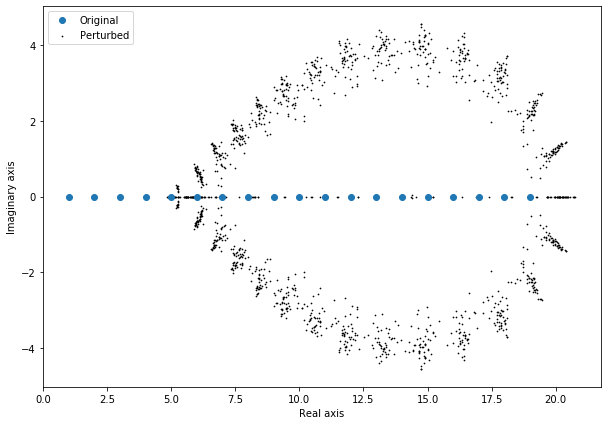

In [7]:
experiment(20)

# Question 3

In [8]:
def cond_eigen(A):
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j * imags
    λ = scipy.linalg.eigvals(A)
    λ_hat = scipy.linalg.eigvals(A + H)
    abs_cond = norm(λ - λ_hat) / norm(H)
    rel_cond = (norm(A)/norm(λ)) * abs_cond
    return abs_cond, rel_cond


In [9]:
cond_eigen(A)

(0.9922518315887573, 1.0892589934500085)

# Q4

In [10]:
def rel_plot(xmin, xmax, ymin, ymax, res):
    
    grid_x = np.linspace(xmin, xmax, res)
    grid_y = np.linspace(ymin, ymax, res)
    
    x, y = np.meshgrid(grid_x, grid_y)
    rel_conds = np.empty((res, res))
    
    for i, x_i in enumerate(grid_x):
        for j, y_i in enumerate(grid_y):
            A = np.array([[1,  x_i], 
                          [y_i, 1]])
            rel_conds[i, j] = cond_eigen(A)[1]
                                
    plt.pcolormesh(x, y, rel_conds, cmap='gray_r')
    plt.colorbar()
    
    plt.show()

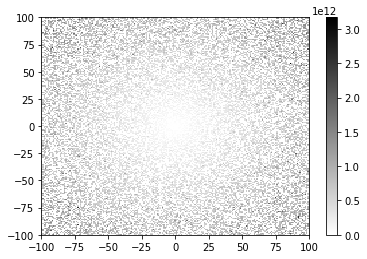

In [11]:
rel_plot(-100, 100, -100, 100, 200)

# q 5

In [12]:
def fit_polynomial(n):   
    
    xk, yk = np.load('stability_data.npy').T
    A = np.vander(xk, n+1)
    
    x_inv = scipy.linalg.inv(A.T @ A) @ A.T @ yk
    error_inv = norm(A @ x_inv - yk)
    
    print(f'The inverse method has a forward error of {error_inv:.2f}')
    
    Q, R = qr(A, mode='economic')
    x_qr = solve_triangular(R, Q.T @ yk)
    error_qr = norm(A @ x_qr - yk)
    
    print(f'The QR method has a forward error of {error_qr:.2f}')
    
    plt.figure(figsize=(10, 6))
    plt.plot(xk, np.polyval(x_inv, xk), label='Normal equations')
    plt.plot(xk, np.polyval(x_qr, xk), label='QR Solver')
    plt.plot(xk, yk, '.', c='k')
    plt.legend()
    plt.show()

The inverse method has a forward error of 129.24
The QR method has a forward error of 4.53


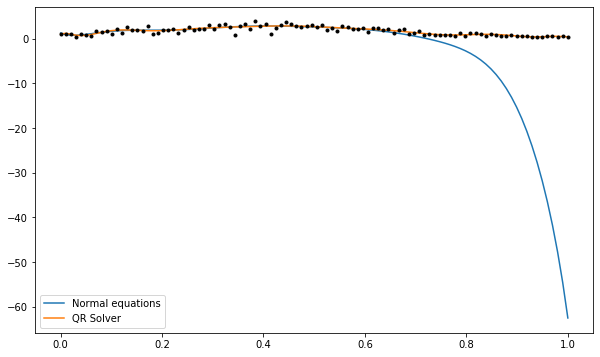

In [13]:
fit_polynomial(15) #yikes

# Question 6

In [14]:
def forward_error():
    
    x = symbols('x')
    n_list = np.arange(5, 50, 5)
    
    errors = np.empty(10)
    
    for i, n in enumerate(n_list):
        integral = N(integrate(x**n * exp(x-1), (x, 0, 1)))
        sf = (-1)**n * subfactorial(n) + (-1)**(n+1) * factorial(n) / e
        errors[i] = np.abs(integral - sf)
        
    plt.plot(np.log(errors))
    plt.show()

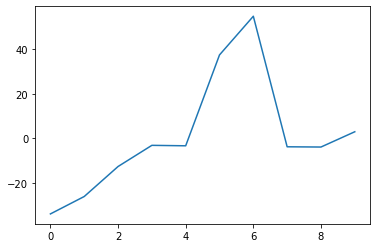

In [15]:
forward_error()